## Imports & Settings

In [1]:
# Update working directory to parent so that we may use our custom functions
import os
os.chdir('..')
# os.getcwd( )


In [2]:

import pandas as pd
import itertools
import re
from ast import literal_eval
from datasets import load_from_disk
def most_common(lst):
    return max(set(lst), key=lst.count)

from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

## Load Test Data

In [3]:
# load test data
dataset_path = "data/target_iSarcasmEval/itesd_iSarcasmEval_balanced.hf"
datasets = load_from_disk(dataset_path)
iSarcasm_test_df = datasets['test'].to_pandas()

true_preds = iSarcasm_test_df['label'].to_list()

In [6]:
print(len(true_preds))
print(type(true_preds))

1400
<class 'list'>


## Load Model Results Dataset

In [7]:
results_df = pd.read_csv('04_results/results_target.csv', converters={'predictions': pd.eval})

results_df.head()

,model_name,model_epoch,test_accuracy,test_f1,predictions
0,control_iSarcasm_01,E01_A0.75_F0.41,0.835714,0.454976,"[0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,control_iSarcasm_01,E02_A0.77_F0.39,0.825714,0.452915,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."
2,control_iSarcasm_01,E03_A0.75_F0.45,0.784286,0.430189,"[0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."
3,control_iSarcasm_01,E04_A0.76_F0.5,0.757857,0.402116,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."
4,control_iSarcasm_01,E05_A0.74_F0.45,0.768571,0.408759,"[0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."


In [8]:
results_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180 entries, 0 to 179
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   model_name     180 non-null    object 
 1   model_epoch    180 non-null    object 
 2   test_accuracy  180 non-null    float64
 3   test_f1        180 non-null    float64
 4   predictions    180 non-null    object 
dtypes: float64(2), object(3)
memory usage: 7.2+ KB


## Filter Dataset
Below, we filter the dataset to retrieve only the best models by F1 score.

In [9]:
idx = results_df.groupby(['model_name'])['test_f1'].transform(max) == results_df['test_f1']

f1_estimators_df = results_df[idx]


patternDel = ".*control.*"
filter = f1_estimators_df['model_name'].str.contains(patternDel)

f1_estimators_df = f1_estimators_df[~filter]
f1_estimators_df

,model_name,model_epoch,test_accuracy,test_f1,predictions
36,target-iSarcasm_inter-SARC_01,E07_A0.77_F0.45,0.810714,0.455852,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, ..."
43,target-iSarcasm_inter-SARC_02,E04_A0.77_F0.4,0.805000,0.457256,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."
53,target-iSarcasm_inter-SARC_03,E04_A0.8_F0.4,0.839286,0.494382,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
68,target-iSarcasm_inter-XED-binary_01,E09_A0.74_F0.32,0.812857,0.471774,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, ..."
72,target-iSarcasm_inter-XED-binary_02,E03_A0.73_F0.38,0.769286,0.434326,"[0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ..."
82,target-iSarcasm_inter-XED-binary_03,E03_A0.76_F0.37,0.831429,0.458716,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
99,target-iSarcasm_inter-XED-fine_01,E10_A0.77_F0.47,0.805000,0.443992,"[0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, ..."
109,target-iSarcasm_inter-XED-fine_02,E10_A0.77_F0.45,0.795714,0.432540,"[0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
111,target-iSarcasm_inter-XED-fine_03,E02_A0.77_F0.47,0.782857,0.419847,"[0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, ..."
129,target-iSarcasm_inter-IMDB_01,E10_A0.73_F0.44,0.730714,0.370618,"[0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."


In [10]:
f1_estimators_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15 entries, 36 to 177
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   model_name     15 non-null     object 
 1   model_epoch    15 non-null     object 
 2   test_accuracy  15 non-null     float64
 3   test_f1        15 non-null     float64
 4   predictions    15 non-null     object 
dtypes: float64(2), object(3)
memory usage: 720.0+ bytes


## Self-Select Estimators

In [ ]:
f1_estimators_df.loc[f1_estimators_df['model_name']=='target-iSarcasm_inter-XED-binary_01', 'predictions'].tolist()[0]

In [ ]:
# use all estimators 
# estimators = estimators_df['model_name'].to_list()

# define particular estimators 
estimators = ['target-iSarcasm_inter-XED-binary_01', 'target-iSarcasm_inter-XED-binary_02', 'target-iSarcasm_inter-XED-binary_03','target-iSarcasm_inter-SARC_01', 'target-iSarcasm_inter-SARC_02', 'target-iSarcasm_inter-SARC_03','target-iSarcasm_inter-hellaswag_01', 'target-iSarcasm_inter-hellaswag_02', 'target-iSarcasm_inter-hellaswag_03']

# get predictions of the defined estimators
predictions =  [f1_estimators_df.loc[f1_estimators_df['model_name']==m, 'predictions'].tolist()[0] for m in estimators]

print(estimators)
print(len(predictions))


In [ ]:
pred_groups = []
for i in range(len(true_preds)):
    pred_stage = []
    for prediction in predictions:
        pred_stage.append(prediction[i])
    pred_groups.append(pred_stage)

# print(pred_groups[0])
# print(pred_groups[1])
# print(pred_groups[2])
# print(pred_groups[3])
# print(pred_groups[4])



In [ ]:
for i in range(20):    
    pred_index = i
    the_list = pred_groups[pred_index]
    prediction = max(set(the_list), key=the_list.count)

    if prediction == true_preds[pred_index]:
        print(prediction, true_preds[pred_index])
    else:
        print(prediction, true_preds[pred_index], iSarcasm_df['text'].iloc[i])

In [ ]:
def most_common(lst):
    return max(set(lst), key=lst.count)

ensemble_preds = []

for i in pred_groups:
    ensemble_preds.append(most_common(i))
# print(ensemble_preds)

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

acc = accuracy_score(true_preds, ensemble_preds)
f1 = f1_score(true_preds, ensemble_preds, average='binary')

print(acc)
print(f1)

# Try All Estimator Combinations

In [ ]:
estimators = f1_estimators_df['model_name'].to_list()

# estimators = [1, 3, 3]
combinations = []
for r in range(len(estimators)+1):
    for combination in itertools.combinations(set(estimators), r):
        combinations.append(combination)

three_estimators = []
for i in combinations:
    if len(i) == 3: 
        three_estimators.append(i)

print(three_estimators[0])

In [ ]:
three_estimators

In [ ]:
accuracies = []
f1s = []

for i in three_estimators:
    # TODO DOUBLE CHECK THIS SHIT
    predictions = [f1_estimators_df.loc[f1_estimators_df['model_name']==m, 'predictions'].tolist()[0] for m in i]

    pred_groups = []
    for j in range(len(true_preds)):
        pred_stage = []
        for prediction in predictions:
            pred_stage.append(prediction[j])
        pred_groups.append(pred_stage)

    ensemble_preds = []
    for k in pred_groups:
        ensemble_preds.append(most_common(k))
    
    acc = accuracy_score(true_preds, ensemble_preds)
    f1 = f1_score(true_preds, ensemble_preds, average='binary')
    accuracies.append(acc)
    f1s.append(f1)
    # print(acc, f1)

In [ ]:
max(accuracies)

In [ ]:
max(f1s)

# Structured Model Strategy

In order to get sets of three models, each containing all three top epochs for each model iteration, follow these steps:

In [18]:
# 1. make list of core model names
estimator_names = ['target-iSarcasm_inter-SARC', 
                   'target-iSarcasm_inter-XED-fine', 
                   'target-iSarcasm_inter-XED-binary', 
                   'target-iSarcasm_inter-IMDB', 
                   'target-iSarcasm_inter-HellaSwag']

# 2. using above methods, get superset of all unique combinations of 3 (and more?) core model names - itertools.combinations
combinations = []
for r in range(len(estimator_names)+1):
    for combination in itertools.combinations(set(estimator_names), r):
        combinations.append(combination)

three_estimators = []
for i in combinations:
    if len(i) == 3: 
        three_estimators.append(i)

print(three_estimators[0])

('target-iSarcasm_inter-IMDB', 'target-iSarcasm_inter-HellaSwag', 'target-iSarcasm_inter-XED-binary')


In [19]:
len(three_estimators)


10

In [20]:
# 3. we are working from best df, so for each list created in step 2, triplicate each core model name and add _01, _02, _03
# this allows us to query the df for those specific model predictions in unique sets of three, containing all three best iterations of each model
new_three_estimators = []
for i in three_estimators:
    triplets = []
    for j in i:
        triplets.append(j + "_01")
        triplets.append(j + "_02")
        triplets.append(j + "_03")
    new_three_estimators.append(tuple(triplets))

In [21]:
new_three_estimators

[('target-iSarcasm_inter-IMDB_01',
  'target-iSarcasm_inter-IMDB_02',
  'target-iSarcasm_inter-IMDB_03',
  'target-iSarcasm_inter-HellaSwag_01',
  'target-iSarcasm_inter-HellaSwag_02',
  'target-iSarcasm_inter-HellaSwag_03',
  'target-iSarcasm_inter-XED-binary_01',
  'target-iSarcasm_inter-XED-binary_02',
  'target-iSarcasm_inter-XED-binary_03'),
 ('target-iSarcasm_inter-IMDB_01',
  'target-iSarcasm_inter-IMDB_02',
  'target-iSarcasm_inter-IMDB_03',
  'target-iSarcasm_inter-HellaSwag_01',
  'target-iSarcasm_inter-HellaSwag_02',
  'target-iSarcasm_inter-HellaSwag_03',
  'target-iSarcasm_inter-SARC_01',
  'target-iSarcasm_inter-SARC_02',
  'target-iSarcasm_inter-SARC_03'),
 ('target-iSarcasm_inter-IMDB_01',
  'target-iSarcasm_inter-IMDB_02',
  'target-iSarcasm_inter-IMDB_03',
  'target-iSarcasm_inter-HellaSwag_01',
  'target-iSarcasm_inter-HellaSwag_02',
  'target-iSarcasm_inter-HellaSwag_03',
  'target-iSarcasm_inter-XED-fine_01',
  'target-iSarcasm_inter-XED-fine_02',
  'target-iSarcas

In [22]:
print(len(new_three_estimators))
print(type(new_three_estimators))

10
<class 'list'>


In [23]:
# 4. collect sets of predictions via each unique collection, and operate on predictions as above.
accuracies = []
f1s = []

three_estimators

results = {"ensemble_id":[], "inducers": [], "inducers_spec":[], "dataset":[], "accuracies":[], "f1s":[]}
for i, v in enumerate(new_three_estimators):
    predictions = [f1_estimators_df.loc[f1_estimators_df['model_name']==m, 'predictions'].tolist()[0] for m in v]

    pred_groups = []
    
    for j in range(len(true_preds)):
        pred_stage = []
        for prediction in predictions:
            pred_stage.append(prediction[j])
        pred_groups.append(pred_stage)

    ensemble_preds = []
    for k in pred_groups:
        ensemble_preds.append(most_common(k))
    
    acc = accuracy_score(true_preds, ensemble_preds)
    f1 = f1_score(true_preds, ensemble_preds, average='binary')
    
    results["ensemble_id"].append(f"ensemble_{i}")
    results["inducers"].append(three_estimators[i])
    results["inducers_spec"].append(v)
    results["dataset"].append("iSarcasm_test")
    results["accuracies"].append(acc)
    results["f1s"].append(f1)




    accuracies.append(acc)
    f1s.append(f1)
    # print(acc, f1)

In [24]:
results_df = pd.DataFrame.from_dict(results)
results_df = results_df.sort_values(by=['accuracies'], ascending=False)

In [25]:
pd.set_option('display.max_colwidth', None)

# TODO NOTE THAT WHILE THE MAX F1 DOES NOT EXCEED PREVIOUS MAX F1, THE AVERAGE CERTAINLY DOES.
# WE SHOULD ONLY COMPARE THIS DATA TO DATA FROM BEST EPOCHS
results_df

,ensemble_id,inducers,inducers_spec,dataset,accuracies,f1s
6,ensemble_6,"(target-iSarcasm_inter-HellaSwag, target-iSarcasm_inter-XED-binary, target-iSarcasm_inter-SARC)","(target-iSarcasm_inter-HellaSwag_01, target-iSarcasm_inter-HellaSwag_02, target-iSarcasm_inter-HellaSwag_03, target-iSarcasm_inter-XED-binary_01, target-iSarcasm_inter-XED-binary_02, target-iSarcasm_inter-XED-binary_03, target-iSarcasm_inter-SARC_01, target-iSarcasm_inter-SARC_02, target-iSarcasm_inter-SARC_03)",iSarcasm_test,0.855000,0.503667
0,ensemble_0,"(target-iSarcasm_inter-IMDB, target-iSarcasm_inter-HellaSwag, target-iSarcasm_inter-XED-binary)","(target-iSarcasm_inter-IMDB_01, target-iSarcasm_inter-IMDB_02, target-iSarcasm_inter-IMDB_03, target-iSarcasm_inter-HellaSwag_01, target-iSarcasm_inter-HellaSwag_02, target-iSarcasm_inter-HellaSwag_03, target-iSarcasm_inter-XED-binary_01, target-iSarcasm_inter-XED-binary_02, target-iSarcasm_inter-XED-binary_03)",iSarcasm_test,0.852857,0.471795
8,ensemble_8,"(target-iSarcasm_inter-HellaSwag, target-iSarcasm_inter-SARC, target-iSarcasm_inter-XED-fine)","(target-iSarcasm_inter-HellaSwag_01, target-iSarcasm_inter-HellaSwag_02, target-iSarcasm_inter-HellaSwag_03, target-iSarcasm_inter-SARC_01, target-iSarcasm_inter-SARC_02, target-iSarcasm_inter-SARC_03, target-iSarcasm_inter-XED-fine_01, target-iSarcasm_inter-XED-fine_02, target-iSarcasm_inter-XED-fine_03)",iSarcasm_test,0.852857,0.490099
1,ensemble_1,"(target-iSarcasm_inter-IMDB, target-iSarcasm_inter-HellaSwag, target-iSarcasm_inter-SARC)","(target-iSarcasm_inter-IMDB_01, target-iSarcasm_inter-IMDB_02, target-iSarcasm_inter-IMDB_03, target-iSarcasm_inter-HellaSwag_01, target-iSarcasm_inter-HellaSwag_02, target-iSarcasm_inter-HellaSwag_03, target-iSarcasm_inter-SARC_01, target-iSarcasm_inter-SARC_02, target-iSarcasm_inter-SARC_03)",iSarcasm_test,0.852143,0.453826
2,ensemble_2,"(target-iSarcasm_inter-IMDB, target-iSarcasm_inter-HellaSwag, target-iSarcasm_inter-XED-fine)","(target-iSarcasm_inter-IMDB_01, target-iSarcasm_inter-IMDB_02, target-iSarcasm_inter-IMDB_03, target-iSarcasm_inter-HellaSwag_01, target-iSarcasm_inter-HellaSwag_02, target-iSarcasm_inter-HellaSwag_03, target-iSarcasm_inter-XED-fine_01, target-iSarcasm_inter-XED-fine_02, target-iSarcasm_inter-XED-fine_03)",iSarcasm_test,0.848571,0.456410
7,ensemble_7,"(target-iSarcasm_inter-HellaSwag, target-iSarcasm_inter-XED-binary, target-iSarcasm_inter-XED-fine)","(target-iSarcasm_inter-HellaSwag_01, target-iSarcasm_inter-HellaSwag_02, target-iSarcasm_inter-HellaSwag_03, target-iSarcasm_inter-XED-binary_01, target-iSarcasm_inter-XED-binary_02, target-iSarcasm_inter-XED-binary_03, target-iSarcasm_inter-XED-fine_01, target-iSarcasm_inter-XED-fine_02, target-iSarcasm_inter-XED-fine_03)",iSarcasm_test,0.847857,0.489209
3,ensemble_3,"(target-iSarcasm_inter-IMDB, target-iSarcasm_inter-XED-binary, target-iSarcasm_inter-SARC)","(target-iSarcasm_inter-IMDB_01, target-iSarcasm_inter-IMDB_02, target-iSarcasm_inter-IMDB_03, target-iSarcasm_inter-XED-binary_01, target-iSarcasm_inter-XED-binary_02, target-iSarcasm_inter-XED-binary_03, target-iSarcasm_inter-SARC_01, target-iSarcasm_inter-SARC_02, target-iSarcasm_inter-SARC_03)",iSarcasm_test,0.843571,0.491879
5,ensemble_5,"(target-iSarcasm_inter-IMDB, target-iSarcasm_inter-SARC, target-iSarcasm_inter-XED-fine)","(target-iSarcasm_inter-IMDB_01, target-iSarcasm_inter-IMDB_02, target-iSarcasm_inter-IMDB_03, target-iSarcasm_inter-SARC_01, target-iSarcasm_inter-SARC_02, target-iSarcasm_inter-SARC_03, target-iSarcasm_inter-XED-fine_01, target-iSarcasm_inter-XED-fine_02, target-iSarcasm_inter-XED-fine_03)",iSarcasm_test,0.840714,0.489703
9,ensemble_9,"(target-iSarcasm_inter-XED-binary, target-iSarcasm_inter-SARC, target-iSarcasm_inter-XED-fine)","(target-iSarcasm_inter-XED-binary_01, target-iSarcasm_inter-XED-binary_02, target-iSarcasm_inter-XED-binary_03, target-iSarcasm_inter-SARC_01, target-iSarcasm_inter-SARC_02, target-iSarcasm_inter-SARC_03, target-iSarcasm_inter-XED-fine_01

In [26]:
results_df.describe()

,accuracies,f1s
count,10.000000,10.000000
mean,0.846429,0.481870
std,0.007408,0.016566
min,0.832857,0.453826
25%,0.841429,0.473266
50%,0.848214,0.489456
75%,0.852679,0.491434
max,0.855000,0.503667


In [27]:
f1_estimators_df.describe()

,test_accuracy,test_f1
count,15.000000,15.000000
mean,0.806810,0.428384
std,0.029222,0.035742
min,0.730714,0.370618
25%,0.800357,0.404618
50%,0.810714,0.432540
75%,0.824643,0.456554
max,0.847143,0.494382


In [28]:
max(accuracies)

0.855

In [29]:
max(f1s)

0.5036674816625918

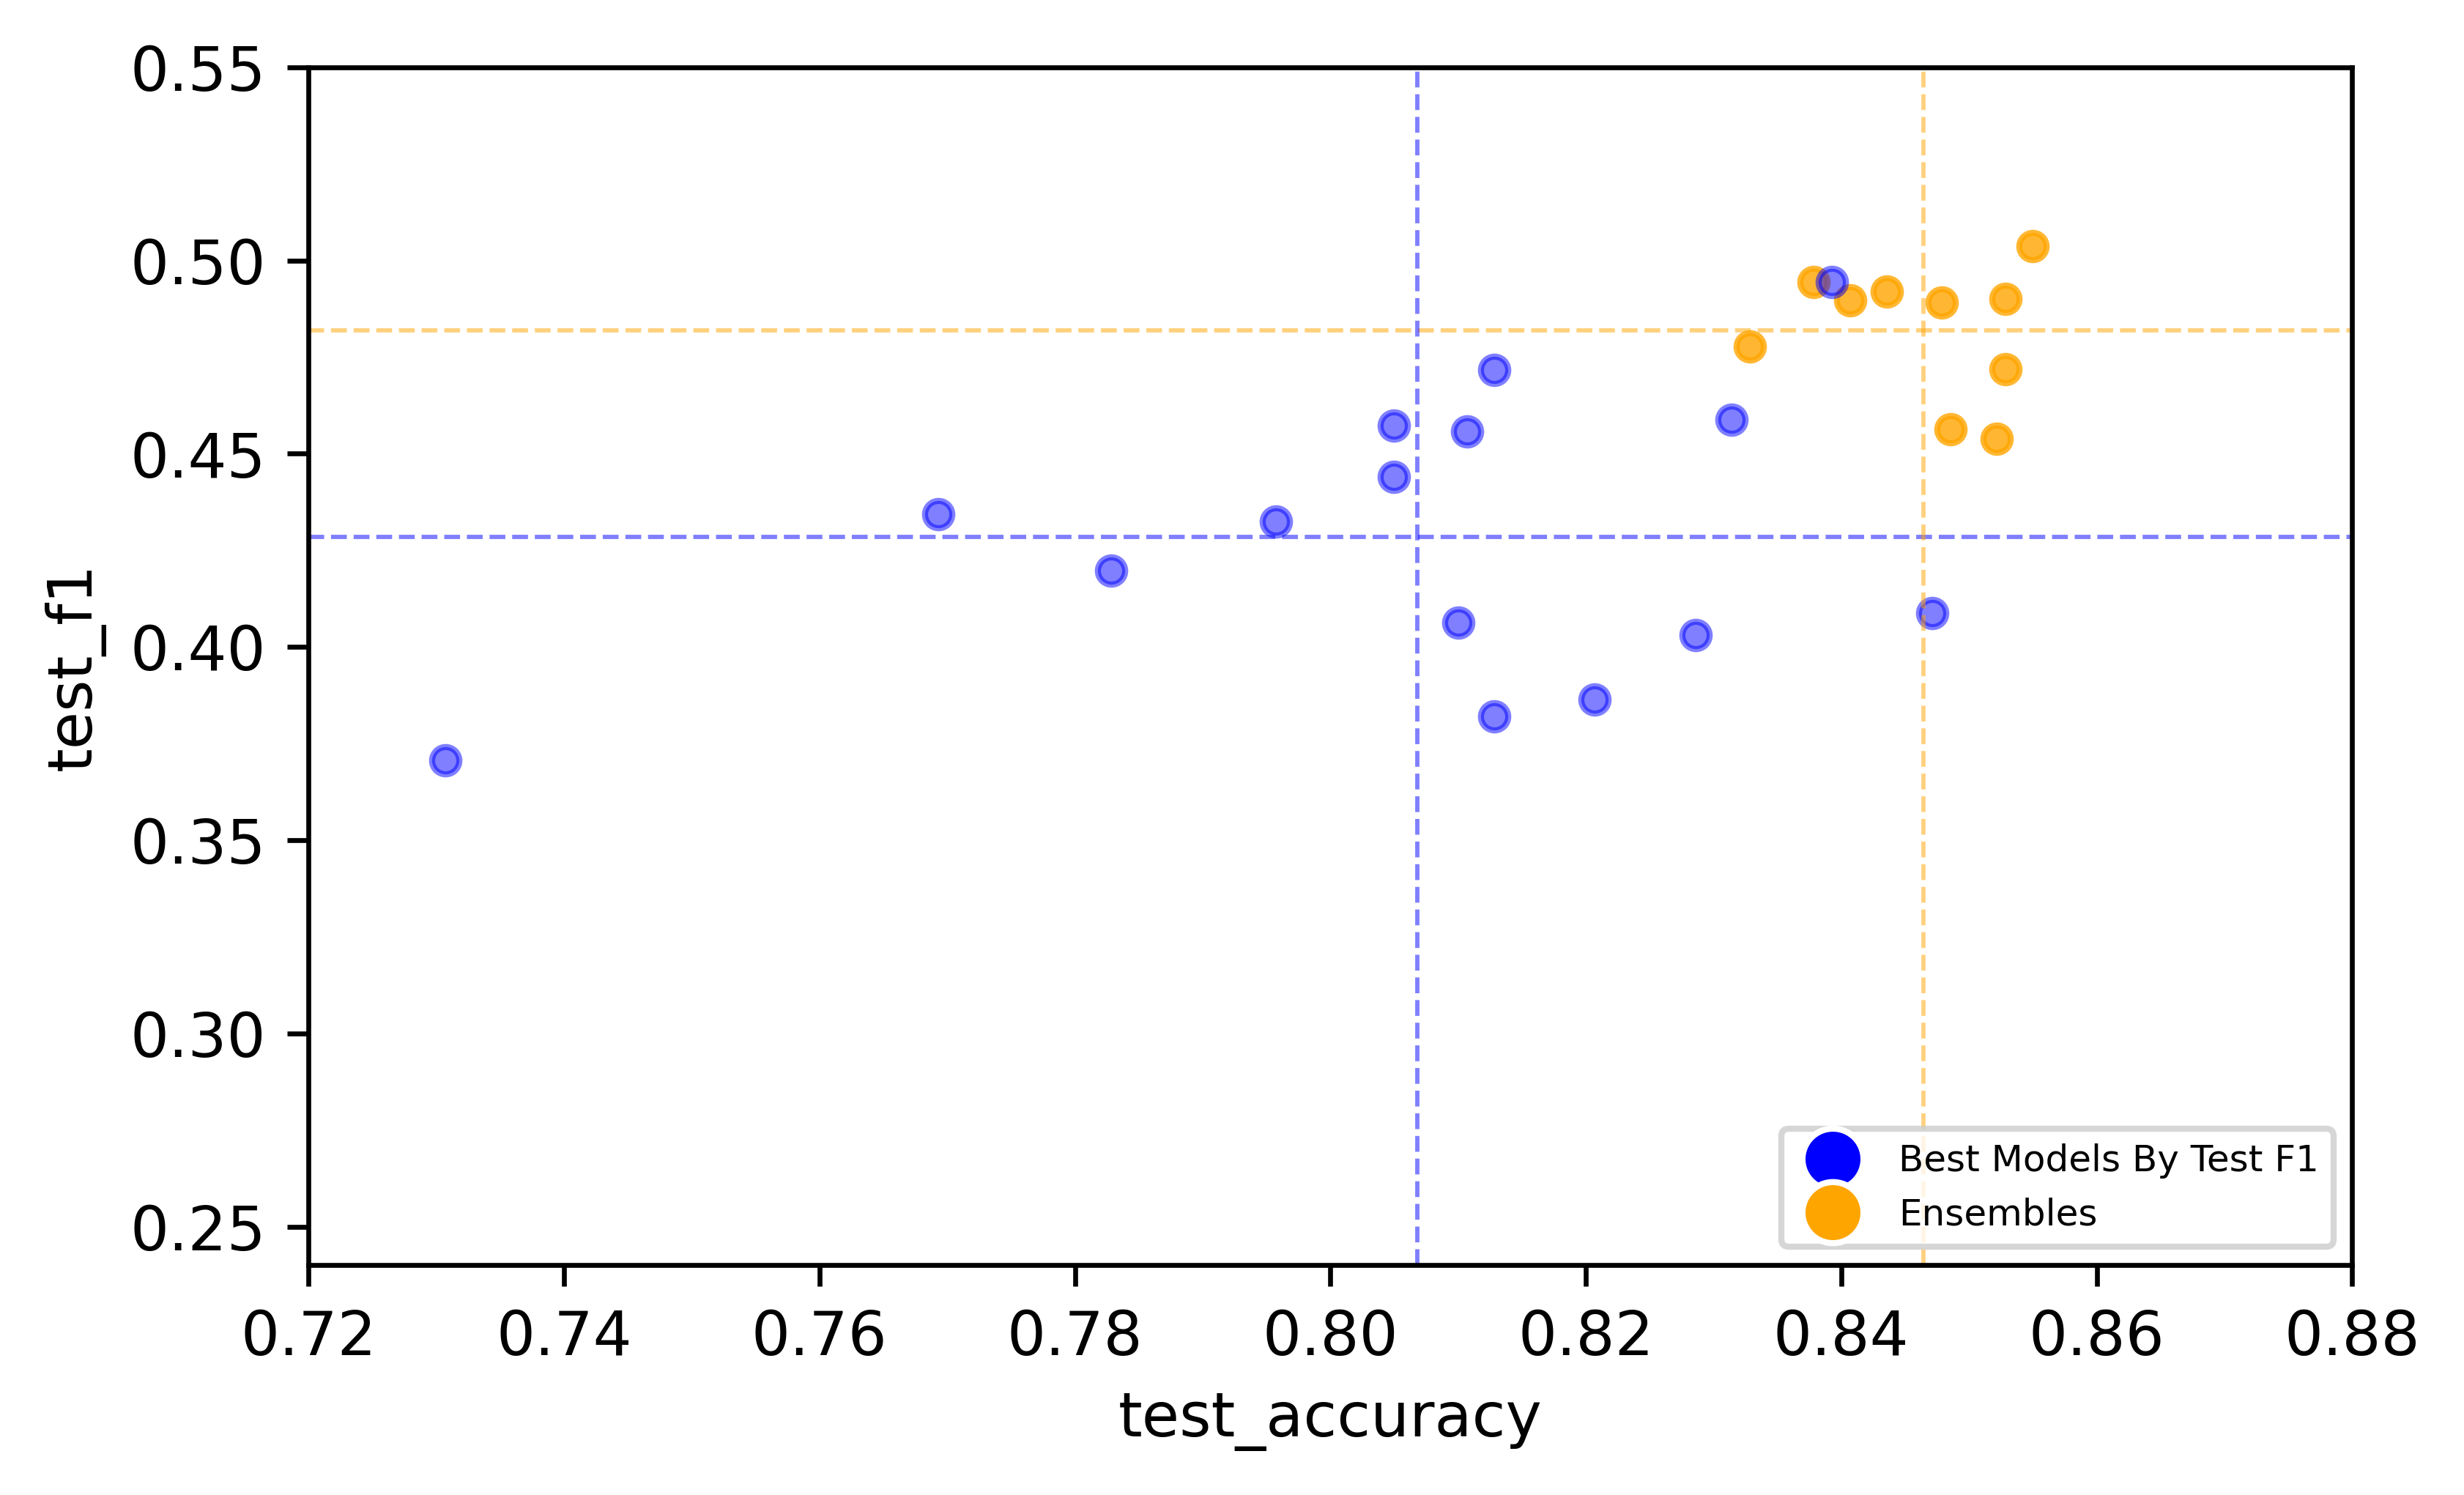

In [34]:
# BEST MODELS BY F1 SCORE, AGAINST ENSMBELS OF SAID MODELS

# plt.scatter(results_df["accuracies"], results_df["f1s"])
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D


fig, ax = plt.subplots(figsize=(6, 3.54), dpi=600)

results_df.plot.scatter(x='accuracies', y='f1s', edgecolor='orange', c='orange', alpha=.8, ax=ax)
f1_estimators_df.plot.scatter(x='test_accuracy', y='test_f1', edgecolor='blue', c='blue', alpha=.5, ax=ax)



legend_elements = [Line2D([0], [0], marker='o', color='w', label='Best Models By Test F1',
                          markerfacecolor='blue', markersize=10),
                   Line2D([0], [0], marker='o', color='w', label='Ensembles', markerfacecolor='orange', markersize=10)]


ax.legend(handles=legend_elements, loc='lower right', fontsize=6)

plt.axhline(y = results_df['f1s'].mean(), color = 'orange', linestyle = 'dashed', alpha=.5, linewidth=.7)
plt.axhline(y = f1_estimators_df['test_f1'].mean(), color = 'blue', linestyle = 'dashed', alpha=.5, linewidth=.7)

plt.axvline(x = results_df['accuracies'].mean(), color = 'orange', linestyle = 'dashed', alpha=.5, linewidth=.7)
plt.axvline(x = f1_estimators_df['test_accuracy'].mean(), color = 'blue', linestyle = 'dashed', alpha=.5, linewidth=.7)

plt.ylim(0.24, 0.55)
plt.xlim(0.72, 0.88)



plt.show()

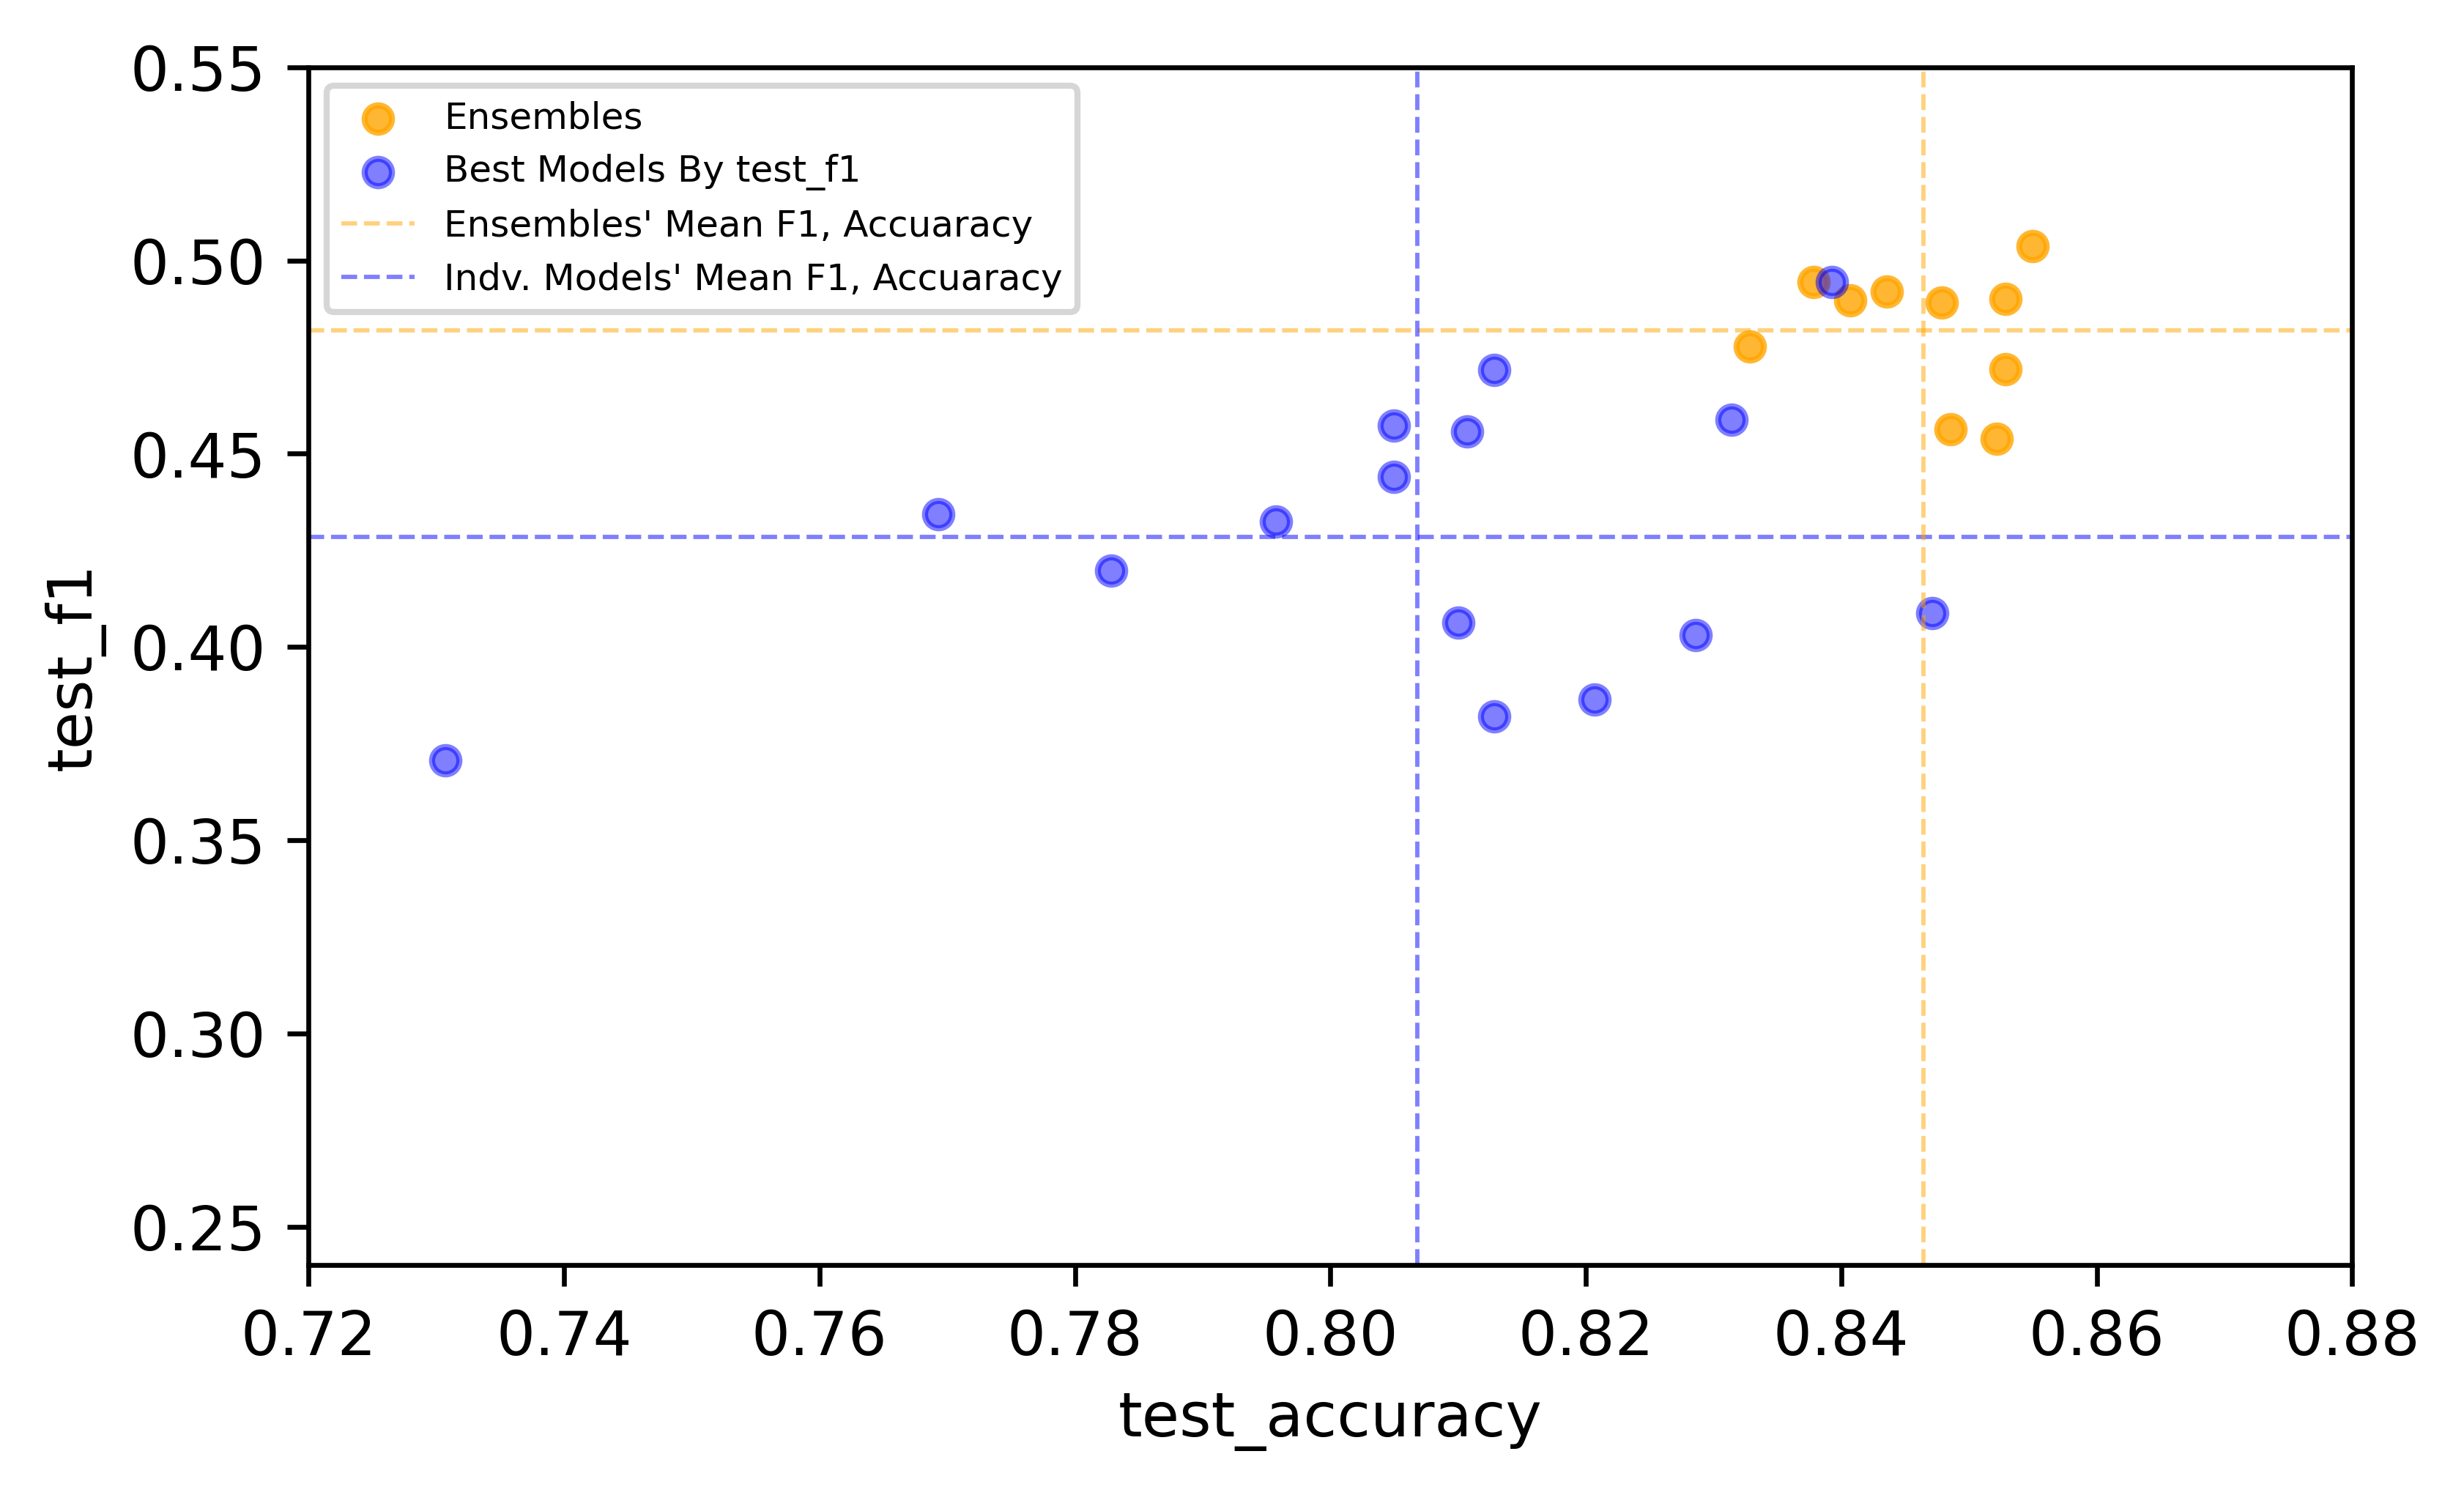

In [35]:
fig, ax = plt.subplots(figsize=(6, 3.54), dpi=600)
# fig, ax = plt.subplots(figsize=(6, 3.54), dpi=600)

results_df.plot.scatter(x='accuracies', y='f1s', edgecolor='orange', c='orange', alpha=.8, label='Ensembles', ax=ax)
f1_estimators_df.plot.scatter(x='test_accuracy', y='test_f1', edgecolor='blue', c='blue', alpha=.5, label='Best Models By test_f1', ax=ax)

plt.axhline(y = results_df['f1s'].mean(), color = 'orange', linestyle = 'dashed', alpha=.5, linewidth=.7, label="Ensembles' Mean F1, Accuaracy")
plt.axhline(y = f1_estimators_df['test_f1'].mean(), color = 'blue', linestyle = 'dashed', alpha=.5, linewidth=.7, label="Indv. Models' Mean F1, Accuaracy")

plt.axvline(x = results_df['accuracies'].mean(), color = 'orange', linestyle = 'dashed', alpha=.5, linewidth=.7)
plt.axvline(x = f1_estimators_df['test_accuracy'].mean(), color = 'blue', linestyle = 'dashed', alpha=.5, linewidth=.7)

plt.ylim(0.24, 0.55)
plt.xlim(0.72, 0.88)

plt.legend(loc='upper left', fontsize=6)

plt.show()